In [1]:
# datetime - hourly date + timestamp  
# season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
# holiday - whether the day is considered a holiday
# workingday - whether the day is neither a weekend nor holiday
# weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
# 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
# 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
# 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
# temp - temperature in Celsius
# atemp - "feels like" temperature in Celsius
# humidity - relative humidity
# windspeed - wind speed
# casual - number of non-registered user rentals initiated
# registered - number of registered user rentals initiated
# count - number of total rentals

In [2]:
import pylab
import calendar
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from datetime import datetime
import matplotlib.pyplot as plt
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

## Load Dataset

In [3]:
train = pd.read_csv("train.csv")
print(train.shape)
train.head()

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [4]:
test = pd.read_csv("test.csv")
print(test.shape)
test.head()

(6493, 9)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


## Preprocessing

In [5]:
# 시간 단위로 추출을 위해 데이터 타입을 datetime 으로 변경해줘야함
train["datetime"] = pd.to_datetime(train["datetime"])
train["datetime"].head()

0   2011-01-01 00:00:00
1   2011-01-01 01:00:00
2   2011-01-01 02:00:00
3   2011-01-01 03:00:00
4   2011-01-01 04:00:00
Name: datetime, dtype: datetime64[ns]

In [6]:
test["datetime"] = pd.to_datetime(test["datetime"])
test["datetime"].head()

0   2011-01-20 00:00:00
1   2011-01-20 01:00:00
2   2011-01-20 02:00:00
3   2011-01-20 03:00:00
4   2011-01-20 04:00:00
Name: datetime, dtype: datetime64[ns]

In [7]:
# dt.시간단위 를 통해 해당 시간단위로 데이터 구분 가능
train["datetime-year"] = train["datetime"].dt.year
train["datetime-month"] = train["datetime"].dt.month
train["datetime-day"] = train["datetime"].dt.day
train["datetime-hour"] = train["datetime"].dt.hour
train["datetime-minute"] = train["datetime"].dt.minute
train["datetime-second"] = train["datetime"].dt.second

# dayofweek는 날짜에서 요일(월~일)을 가져오는 기능입니다.
# 값은 0(월), 1(화), 2(수), 3(목), 4(금), 5(토), 6(일) 을 나타냅니다.
train["datetime-dayofweek"] = train["datetime"].dt.dayofweek

print(train.shape)
train[["datetime", "datetime-year", "datetime-month", "datetime-day", "datetime-hour", "datetime-minute", "datetime-second", "datetime-dayofweek"]].head()

# train = train.sort_values(by=["datetime"])
# train.to_csv("train2.csv", index = False)

(10886, 19)


,datetime,datetime-year,datetime-month,datetime-day,datetime-hour,datetime-minute,datetime-second,datetime-dayofweek
0,2011-01-01 00:00:00,2011,1,1,0,0,0,5
1,2011-01-01 01:00:00,2011,1,1,1,0,0,5
2,2011-01-01 02:00:00,2011,1,1,2,0,0,5
3,2011-01-01 03:00:00,2011,1,1,3,0,0,5
4,2011-01-01 04:00:00,2011,1,1,4,0,0,5


In [8]:
# datetime-dayofweek를 사람이 이해하기 쉬운 표현으로 변경합니다. (Monday ~ Sunday)
# 이를 datetime-dayofweek(humanized)라는 새로운 컬럼에 추가합니다.
train.loc[train["datetime-dayofweek"] == 0, "datetime-dayofweek(humanized)"] = "Monday"
train.loc[train["datetime-dayofweek"] == 1, "datetime-dayofweek(humanized)"] = "Tuesday"
train.loc[train["datetime-dayofweek"] == 2, "datetime-dayofweek(humanized)"] = "Wednesday"
train.loc[train["datetime-dayofweek"] == 3, "datetime-dayofweek(humanized)"] = "Thursday"
train.loc[train["datetime-dayofweek"] == 4, "datetime-dayofweek(humanized)"] = "Friday"
train.loc[train["datetime-dayofweek"] == 5, "datetime-dayofweek(humanized)"] = "Saturday"
train.loc[train["datetime-dayofweek"] == 6, "datetime-dayofweek(humanized)"] = "Sunday"

# train 변수에 할당된 데이터의 행렬 사이즈를 출력합니다.
# 출력은 (row, column) 으로 표시됩니다.
print(train.shape)

# .head()로 train 데이터의 상위 5개를 띄우되,
# datetime과 datetime-dayofweek, 그리고 datetime-dayofweek(humanized) 컬럼만을 출력합니다.
train[["datetime", "datetime-dayofweek", "datetime-dayofweek(humanized)"]].head()

(10886, 20)


,datetime,datetime-dayofweek,datetime-dayofweek(humanized)
0,2011-01-01 00:00:00,5,Saturday
1,2011-01-01 01:00:00,5,Saturday
2,2011-01-01 02:00:00,5,Saturday
3,2011-01-01 03:00:00,5,Saturday
4,2011-01-01 04:00:00,5,Saturday


In [9]:
# test 데이터와 train 데이터와 동일하게 연, 월, 일, 시, 분, 초 컬럼을 생성합니다.
test["datetime-year"] = test["datetime"].dt.year
test["datetime-month"] = test["datetime"].dt.month
test["datetime-day"] = test["datetime"].dt.day
test["datetime-hour"] = test["datetime"].dt.hour
test["datetime-minute"] = test["datetime"].dt.minute
test["datetime-second"] = test["datetime"].dt.second

# dayofweek 컬럼도 train 데이터와 동일하게 생성합니다.
test["datetime-dayofweek"] = test["datetime"].dt.dayofweek

# test 변수에 할당된 데이터의 행렬 사이즈를 출력합니다.
# 출력은 (row, column) 으로 표시됩니다.
print(test.shape)

# .head()로 test 데이터의 상위 5개를 띄우되,
# datetime과 이와 연관된 나머지 일곱 개의 컬럼만을 출력합니다.
test[["datetime", "datetime-year", "datetime-month", "datetime-day", "datetime-hour", "datetime-minute", "datetime-second", "datetime-dayofweek"]].head()

(6493, 16)


,datetime,datetime-year,datetime-month,datetime-day,datetime-hour,datetime-minute,datetime-second,datetime-dayofweek
0,2011-01-20 00:00:00,2011,1,20,0,0,0,3
1,2011-01-20 01:00:00,2011,1,20,1,0,0,3
2,2011-01-20 02:00:00,2011,1,20,2,0,0,3
3,2011-01-20 03:00:00,2011,1,20,3,0,0,3
4,2011-01-20 04:00:00,2011,1,20,4,0,0,3


In [10]:
# datetime-dayofweek를 사람이 이해하기 쉬운 표현으로 변경합니다. (Monday ~ Sunday)
# 이를 datetime-dayofweek(humanized)라는 새로운 컬럼에 추가합니다.
test.loc[test["datetime-dayofweek"] == 0, "datetime-dayofweek(humanized)"] = "Monday"
test.loc[test["datetime-dayofweek"] == 1, "datetime-dayofweek(humanized)"] = "Tuesday"
test.loc[test["datetime-dayofweek"] == 2, "datetime-dayofweek(humanized)"] = "Wednesday"
test.loc[test["datetime-dayofweek"] == 3, "datetime-dayofweek(humanized)"] = "Thursday"
test.loc[test["datetime-dayofweek"] == 4, "datetime-dayofweek(humanized)"] = "Friday"
test.loc[test["datetime-dayofweek"] == 5, "datetime-dayofweek(humanized)"] = "Saturday"
test.loc[test["datetime-dayofweek"] == 6, "datetime-dayofweek(humanized)"] = "Sunday"

# test 변수에 할당된 데이터의 행렬 사이즈를 출력합니다.
# 출력은 (row, column) 으로 표시됩니다.
print(test.shape)

# .head()로 test 데이터의 상위 5개를 띄우되,
# datetime과 datetime-dayofweek, 그리고 datetime-dayofweek(humanized) 컬럼만을 출력합니다.
test[["datetime", "datetime-dayofweek", "datetime-dayofweek(humanized)"]].head()

(6493, 17)


,datetime,datetime-dayofweek,datetime-dayofweek(humanized)
0,2011-01-20 00:00:00,3,Thursday
1,2011-01-20 01:00:00,3,Thursday
2,2011-01-20 02:00:00,3,Thursday
3,2011-01-20 03:00:00,3,Thursday
4,2011-01-20 04:00:00,3,Thursday


In [11]:
data = train.append(test)
data.head()


//anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


,atemp,casual,count,datetime,datetime-day,datetime-dayofweek,datetime-dayofweek(humanized),datetime-hour,datetime-minute,datetime-month,datetime-second,datetime-year,holiday,humidity,registered,season,temp,weather,windspeed,workingday
0,14.395,3.0,16.0,2011-01-01 00:00:00,1,5,Saturday,0,0,1,0,2011,0,81,13.0,1,9.84,1,0.0,0
1,13.635,8.0,40.0,2011-01-01 01:00:00,1,5,Saturday,1,0,1,0,2011,0,80,32.0,1,9.02,1,0.0,0
2,13.635,5.0,32.0,2011-01-01 02:00:00,1,5,Saturday,2,0,1,0,2011,0,80,27.0,1,9.02,1,0.0,0
3,14.395,3.0,13.0,2011-01-01 03:00:00,1,5,Saturday,3,0,1,0,2011,0,75,10.0,1,9.84,1,0.0,0
4,14.395,0.0,1.0,2011-01-01 04:00:00,1,5,Saturday,4,0,1,0,2011,0,75,1.0,1,9.84,1,0.0,0


In [12]:
from sklearn.ensemble import RandomForestRegressor

dataWind0 = data[data["windspeed"]==0]
dataWindNot0 = data[data["windspeed"]!=0]
rfModel_wind = RandomForestRegressor()
windColumns = ["season","weather","humidity","datetime-month","temp","datetime-year","atemp"]
rfModel_wind.fit(dataWindNot0[windColumns], dataWindNot0["windspeed"])

wind0Values = rfModel_wind.predict(X= dataWind0[windColumns])
dataWind0["windspeed"] = wind0Values
data = dataWindNot0.append(dataWind0)

data.head()

//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


,atemp,casual,count,datetime,datetime-day,datetime-dayofweek,datetime-dayofweek(humanized),datetime-hour,datetime-minute,datetime-month,datetime-second,datetime-year,holiday,humidity,registered,season,temp,weather,windspeed,workingday
5,12.880,0.0,1.0,2011-01-01 05:00:00,1,5,Saturday,5,0,1,0,2011,0,75,1.0,1,9.84,2,6.0032,0
10,19.695,12.0,36.0,2011-01-01 10:00:00,1,5,Saturday,10,0,1,0,2011,0,76,24.0,1,15.58,1,16.9979,0
11,16.665,26.0,56.0,2011-01-01 11:00:00,1,5,Saturday,11,0,1,0,2011,0,81,30.0,1,14.76,1,19.0012,0
12,21.210,29.0,84.0,2011-01-01 12:00:00,1,5,Saturday,12,0,1,0,2011,0,77,55.0,1,17.22,1,19.0012,0
13,22.725,47.0,94.0,2011-01-01 13:00:00,1,5,Saturday,13,0,1,0,2011,0,72,47.0,1,18.86,2,19.9995,0


In [13]:
train = data[pd.notnull(data['count'])].sort_values(by=["datetime"])
test = data[pd.isnull(data['count'])].sort_values(by=["datetime"])

In [14]:
drop=["casual","count","registered"]
test  = test.drop(drop,axis=1)

In [15]:
train.loc[train["weather"] == 4 ,"weather"] = 3
train[train["weather"] == 4]

,atemp,casual,count,datetime,datetime-day,datetime-dayofweek,datetime-dayofweek(humanized),datetime-hour,datetime-minute,datetime-month,datetime-second,datetime-year,holiday,humidity,registered,season,temp,weather,windspeed,workingday


In [16]:
test.loc[test["weather"] == 4 ,"weather"] = 3
test[test["weather"] == 4]

,atemp,datetime,datetime-day,datetime-dayofweek,datetime-dayofweek(humanized),datetime-hour,datetime-minute,datetime-month,datetime-second,datetime-year,holiday,humidity,season,temp,weather,windspeed,workingday


In [17]:
train.loc[abs(train["temp"] - train["atemp"]) > 10, "atemp"] = train["temp"]

In [18]:
test.loc[abs(test["temp"] - test["atemp"]) > 10,"atemp"] = test["temp"]

## Explore

In [19]:
import seaborn as sns

# 주피터 노트북 안에서 그래프가 표시되게 합니다.
%matplotlib inline

### datetitme

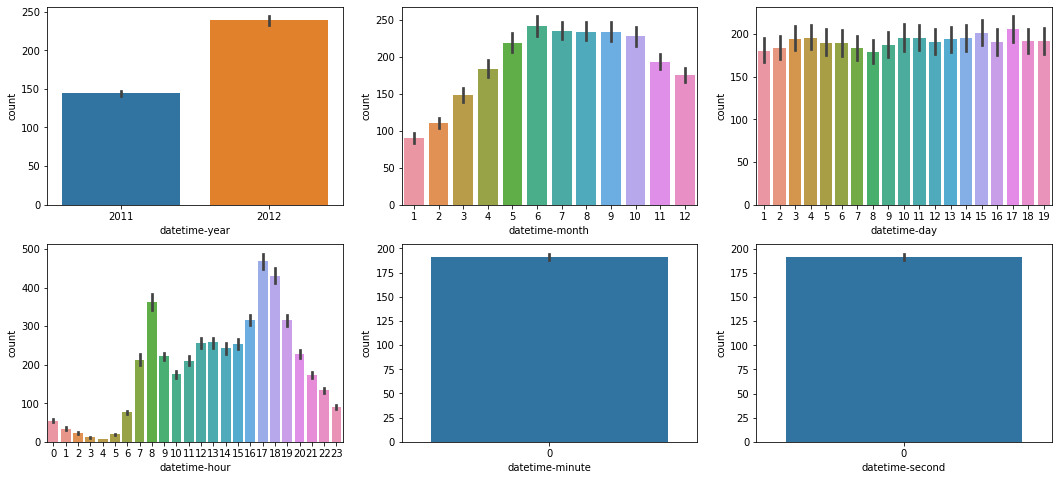

In [20]:
# matplotlib의 subplots를 사용합니다. 이 함수는 여러 개의 시각화를 한 화면에 띄울 수 있도록 합니다.
# 이번에는 2x3으로 총 6개의 시각화를 한 화면에 띄웁니다.
figure, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3)

# 시각화의 전체 사이즈는 18x8로 설정합니다.
figure.set_size_inches(18, 8)

# seaborn의 barplot으로 subplots의 각 구역에
# 연, 월, 일, 시, 분, 초 별 자전거 대여량을 출력합니다.
sns.barplot(data=train, x="datetime-year", y="count", ax=ax1)
sns.barplot(data=train, x="datetime-month", y="count", ax=ax2)
sns.barplot(data=train, x="datetime-day", y="count", ax=ax3)
sns.barplot(data=train, x="datetime-hour", y="count", ax=ax4)
sns.barplot(data=train, x="datetime-minute", y="count", ax=ax5)
sns.barplot(data=train, x="datetime-second", y="count", ax=ax6)

### datetime-year & datetime-month

In [21]:
# datetime-year와 datetime-month의 형태를 변환합니다.
# 이전까지는 정수형(int)였지만, pandas의 astype을 통해 문자열(str)로 변환합니다.
# 이 결과를 datetime-year(str)와 datetime-month(str)라는 새로운 컬럼에 집어넣습니다.
train["datetime-year(str)"] = train["datetime-year"].astype('str')
train["datetime-month(str)"] = train["datetime-month"].astype('str')

# datetime-year(str)와 datetime-month(str) 문자열 두 개를 붙여서 datetime-year_month라는 새로운 컬럼을 추가합니다.
# 이 컬럼에는 2011-1부터 2012-12까지의 총 24의 경우의 수가 들어갑니다.
train["datetime-year_month"] = train["datetime-year(str)"] + "-" + train["datetime-month(str)"]

# train 변수에 할당된 데이터의 행렬 사이즈를 출력합니다.
# 출력은 (row, column) 으로 표시됩니다.
print(train.shape)

# .head() train 데이터의 상위 5개를 띄우되,
# datetime과 datetime-year_month 두 개의 컬럼만 출력합니다.
train[["datetime", "datetime-year_month"]].head()

(10886, 23)


,datetime,datetime-year_month
0,2011-01-01 00:00:00,2011-1
1,2011-01-01 01:00:00,2011-1
2,2011-01-01 02:00:00,2011-1
3,2011-01-01 03:00:00,2011-1
4,2011-01-01 04:00:00,2011-1


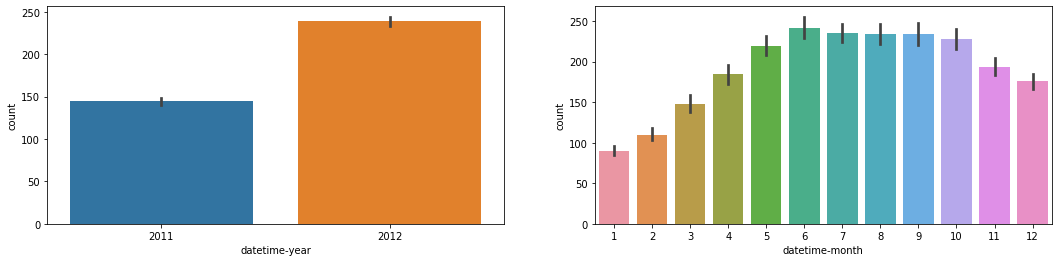

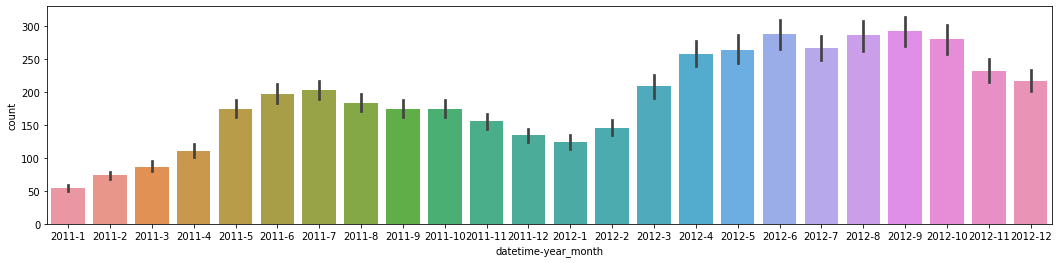

In [22]:
# matplotlib의 subplots를 사용합니다. 이 함수는 여러 개의 시각화를 한 화면에 띄울 수 있도록 합니다.
# 이번에는 1x2로 총 2개의 시각화를 한 화면에 띄웁니다.
figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)

# 시각화의 전체 사이즈는 18x4로 설정합니다.
figure.set_size_inches(18, 4)

# seaborn의 barplot으로 subplots의 각 구역에
# 연, 월별 자전거 대여량을 출력합니다.
sns.barplot(data=train, x="datetime-year", y="count", ax=ax1)
sns.barplot(data=train, x="datetime-month", y="count", ax=ax2)

# 다시 한 번 matplotlib의 subplots를 사용합니다.
# 이번에는 1x1로 1개의 시각화만을 출력합니다.
figure, ax3 = plt.subplots(nrows=1, ncols=1)

# 이 시각화의 전체 사이즈는 18x4로 설정합니다.
figure.set_size_inches(18, 4)

# 이번에는 seaborn의 barplot으로 연-월을 붙여서 자전거 대여량을 출력합니다.
sns.barplot(data=train, x="datetime-year_month", y="count", ax=ax3)

### datatime-hour

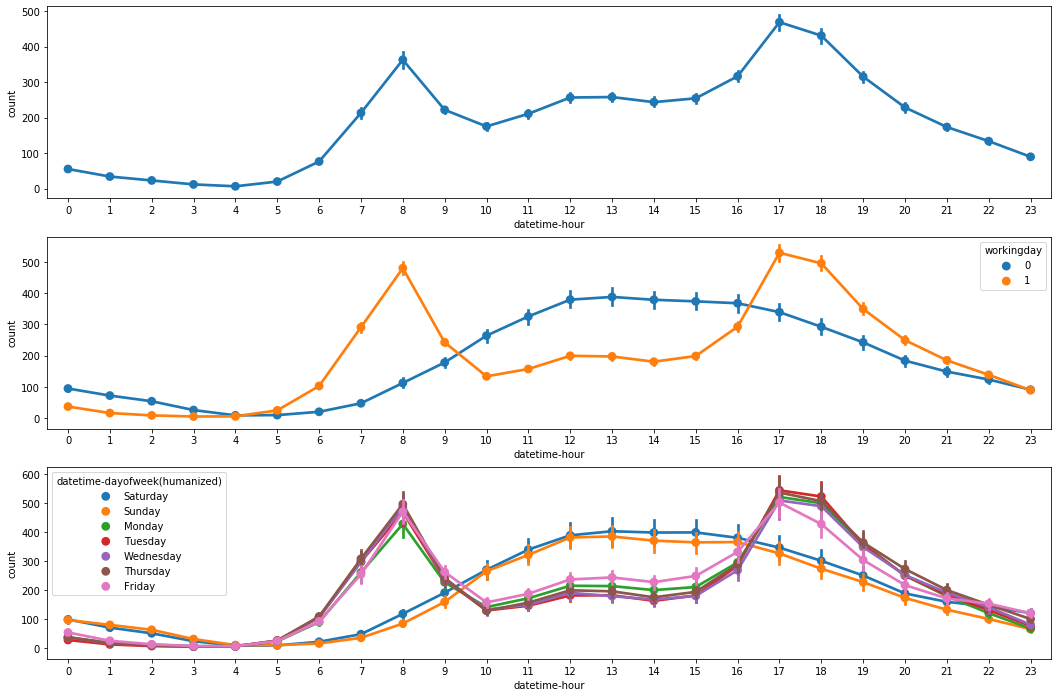

In [23]:
# matplotlib의 subplots를 사용합니다. 이 함수는 여러 개의 시각화를 한 화면에 띄울 수 있도록 합니다.
# 이번에는 3x1로 총 3개의 시각화를 한 화면에 띄웁니다.
figure, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1)

# 시각화의 전체 사이즈는 18x12로 설정합니다.
figure.set_size_inches(18, 12)

# seaborn의 pointplot으로 시각당 자전거 대여량을 시각화합니다.
sns.pointplot(data=train, x="datetime-hour", y="count", ax=ax1)

# 비슷하게 seaborn의 pointplot으로 시각당 자전거 대여량을 시각화합니다.
# 하지만 이번에는 근무일(workingday)에 따른 차이를 보여줍니다.
sns.pointplot(data=train, x="datetime-hour", y="count", hue="workingday", ax=ax2)

# 비슷하게 seaborn의 pointplot으로 시각당 자전거 대여량을 시각화합니다.
# 하지만 이번에는 요일(datetime-dayofweek)에 따른 차이를 보여줍니다.
sns.pointplot(data=train, x="datetime-hour", y="count", hue="datetime-dayofweek(humanized)", ax=ax3)

In [24]:
train[train["weather"] == 4]

,atemp,casual,count,datetime,datetime-day,datetime-dayofweek,datetime-dayofweek(humanized),datetime-hour,datetime-minute,datetime-month,...,humidity,registered,season,temp,weather,windspeed,workingday,datetime-year(str),datetime-month(str),datetime-year_month


In [25]:
train["count"].max()

977.0

In [26]:
train["log_count"] = np.log(train["count"]+1)

In [27]:
train["count(recover)"] = np.exp(train["log_count"]) -1
train[["count","log_count","count(recover)"]].head()

,count,log_count,count(recover)
0,16.0,2.833213,16.0
1,40.0,3.713572,40.0
2,32.0,3.496508,32.0
3,13.0,2.639057,13.0
4,1.0,0.693147,1.0


## Train
* feature_names : 학습에 사용할 컬럼을 리스트 형태로 만듭니다.
* X_train : feature_names 컬럼을 train 데이터셋에서 가져와서 만듭니다.
    * 학습, 훈련에 사용할 데이터셋
    * 예를 들어 시험의 기출문제
* X_test : feature_names 컬럼을 test 데이터셋에서 가져와서 만듭니다.
    * 예측에 사용할 데이터셋
    * 예를 들어 실전 시험문제
* y_train : 학습, 훈련에 사용할 정답 값, 예를 들어 기출문제의 정답.
* model : 학습, 훈련, 예측을 할 머신러닝 모델
* model.fit(X_train, y_train) : 학습 기출문제와 정답을 보고 학습합니다.
* model.predict(X_test) : 예측, 실전 시험을 봅니다.
* Submit
    * sample submission file 을 불러옵니다.(=답안지)
    * 우리가 예측한 값을 답안지에 옮겨 적습니다.
    * to_csv로 케글에 제출할 형태로 저장합니다.
    * 캐글에 제출합니다.

In [45]:
test.columns

Index(['atemp', 'datetime', 'datetime-day', 'datetime-dayofweek',
       'datetime-dayofweek(humanized)', 'datetime-hour', 'datetime-minute',
       'datetime-month', 'datetime-second', 'datetime-year', 'holiday',
       'humidity', 'season', 'temp', 'weather', 'windspeed', 'workingday'],
      dtype='object')

In [46]:
# 총 11개의 컬럼을 feature를 지정합니다.
# 이 11개의 컬럼명을 feature_names라는 이름의 파이썬 리스트(list)로 만들어 변수에 할당합니다.
feature_names = ["season", "holiday", "workingday", "weather",
                 "temp", "atemp", 'humidity', "windspeed",
                 'datetime-year',"datetime-hour", "datetime-dayofweek"]
feature_names

['season',
 'holiday',
 'workingday',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'windspeed',
 'datetime-year',
 'datetime-hour',
 'datetime-dayofweek']

In [47]:
# 자전거 대여량(count)을 label로 지정합니다.
# count라는 이름의 컬럼을 label_name 이라는 이름의 변수에 할당합니다.
label_name = "count"



In [48]:
# feature_names를 활용해 train 데이터의 feature를 가져옵니다.
# 이를 X_train이라는 이름의 변수에 할당합니다.
X_train = train[feature_names]

# X_train 변수에 할당된 데이터의 행렬 사이즈를 출력합니다.
# 출력은 (row, column) 으로 표시됩니다.
print(X_train.shape)

# X_train 데이터의 상위 5개를 띄웁니다.
X_train.head()

(10886, 11)


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,datetime-year,datetime-hour,datetime-dayofweek
0,1,0,0,1,9.84,14.395,81,6.40252,2011,0,5
1,1,0,0,1,9.02,13.635,80,6.00320,2011,1,5
2,1,0,0,1,9.02,13.635,80,6.00320,2011,2,5
3,1,0,0,1,9.84,14.395,75,6.20286,2011,3,5
4,1,0,0,1,9.84,14.395,75,6.20286,2011,4,5


In [49]:
# feature_names를 활용해 test 데이터의 feature를 가져옵니다.
# 이를 X_test라는 이름의 변수에 할당합니다.
X_test = test[feature_names]

# X_test 변수에 할당된 데이터의 행렬 사이즈를 출력합니다.
# 출력은 (row, column) 으로 표시됩니다.
print(X_test.shape)

# X_test 데이터의 상위 5개를 띄웁니다.
X_test.head()

(6493, 11)


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,datetime-year,datetime-hour,datetime-dayofweek
0,1,0,1,1,10.66,11.365,56,26.00270,2011,0,3
1,1,0,1,1,10.66,13.635,56,8.89827,2011,1,3
2,1,0,1,1,10.66,13.635,56,8.89827,2011,2,3
3,1,0,1,1,10.66,12.880,56,11.00140,2011,3,3
4,1,0,1,1,10.66,12.880,56,11.00140,2011,4,3


In [50]:
# 훈련에 사용할 데이터셋. 예를 들어 시험문제
X_test = test[feature_names]

print(X_test.shape)
X_test.head()

(6493, 11)


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,datetime-year,datetime-hour,datetime-dayofweek
0,1,0,1,1,10.66,11.365,56,26.00270,2011,0,3
1,1,0,1,1,10.66,13.635,56,8.89827,2011,1,3
2,1,0,1,1,10.66,13.635,56,8.89827,2011,2,3
3,1,0,1,1,10.66,12.880,56,11.00140,2011,3,3
4,1,0,1,1,10.66,12.880,56,11.00140,2011,4,3


In [51]:
y_train = train[label_name]
y_train = np.log(y_train + 1)
print(y_train.shape)
y_train.head()

(10886,)


0    2.833213
1    3.713572
2    3.496508
3    2.639057
4    0.693147
Name: count, dtype: float64

## Use DecisionTree

In [52]:
# # DecisionTreeRegressor - 분류 가능한 문제에 사용 ( 0 또는 1 ) 
# # DecisionTreeClassifier - 오차범위를 좁히는 문제에 사용 ( 일정범위 )

# from sklearn.tree import DecisionTreeRegressor

# # random_state : 값을 고정하는 역할을 합니다.
# model = DecisionTreeRegressor(random_state=37)
# model

## Use RandomForest

In [63]:
from sklearn.ensemble import RandomForestRegressor

# n_estimators : 사용 모델(트리) 개수 - 많으면 많을수록 좋습니다.
# n_jobs = 사용할 cpu 코어의 수 (-1로 설정해 주면 사용할 수 있는 모든 코어를 다 쓴다.)

model = RandomForestRegressor(n_estimators=10, random_state=37, n_jobs=-1)
model

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                      oob_score=False, random_state=37, verbose=0,
                      warm_start=False)

## Hyperparameter Tuning

In [65]:
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# n_estimators : 사용 모델(트리) 개수 - 많으면 많을수록 좋습니다.
# n_jobs = 사용할 cpu 코어의 수 (-1로 설정해 주면 사용할 수 있는 모든 코어를 다 쓴다.)

# 트리의 갯수
n_estimators = 10
# 트리의 깊이
max_depth_list = [3, 5, 7, 9]
# features 를 몇 % 샘플링 할 것 인지
max_features_list = [0.1, 0.3, 0.5, 0.7, 0.9]
for max_depth in max_depth_list:
   for max_features in max_features_list:
       model = RandomForestRegressor(n_estimators=n_estimators,
                                     max_depth=max_depth,
                                     max_features=max_features,
                                     n_jobs=-1,
                                     random_state=37)
       y_predict = cross_val_predict(model, X_train, y_train, cv=20)
       # label 값에 이미 log를 적용해 주었기 때문에 RMSE로 계산합니다.
       score = mean_squared_error(y_train, y_predict)
       score = np.sqrt(score)
       print(f"""
       n_estimators={n_estimators}, max_depth={max_depth},
       max_features={max_features}, score={score:.5f}
       """)


       n_estimators=10, max_depth=3,
       max_features=0.1, score=1.16532
       

       n_estimators=10, max_depth=3,
       max_features=0.3, score=0.92443
       

       n_estimators=10, max_depth=3,
       max_features=0.5, score=0.78822
       

       n_estimators=10, max_depth=3,
       max_features=0.7, score=0.77240
       

       n_estimators=10, max_depth=3,
       max_features=0.9, score=0.76356
       

       n_estimators=10, max_depth=5,
       max_features=0.1, score=0.95399
       

       n_estimators=10, max_depth=5,
       max_features=0.3, score=0.77185
       

       n_estimators=10, max_depth=5,
       max_features=0.5, score=0.63502
       

       n_estimators=10, max_depth=5,
       max_features=0.7, score=0.61313
       

       n_estimators=10, max_depth=5,
       max_features=0.9, score=0.59305
       

       n_estimators=10, max_depth=7,
       max_features=0.1, score=0.87281
       

       n_estimators=10, max_depth=7,
       max_features=0.3, sc

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# 트리의 갯수
n_estimators = 10
for i in range(10):
   max_depth = np.random.randint(2, 100)
   max_features = np.random.uniform(0.1, 1.0)
   model = RandomForestRegressor(n_estimators=n_estimators,
                                 max_depth=max_depth,
                                 max_features=max_features,
                                 n_jobs=-1,
                                 random_state=37)
   y_predict = cross_val_predict(model, X_train, y_train, cv=20)
   # label 값에 이미 log를 적용해 주었기 때문에 RMSE로 계산합니다.
   score = mean_squared_error(y_train, y_predict)
   score = np.sqrt(score)
   print(f"n_estimators={n_estimators}, max_depth={max_depth}, max_features={max_features:.5f}, score={score:.5f}")

## Score

In [423]:
# scikit-learn의 model_selection 모듈에서 cross_val_score 함수를 가져옵니다.
# 이 함수는 Cross Validation의 모든 기능을 한 번에 실행합니다.
from sklearn.model_selection import cross_val_score

# cross_val_score를 실행합니다. 실행할 때는 다음의 옵션이 들어갑니다.
# 1) model. 점수를 측정할 머신러닝 모델(현재는 Random Forest)이 들어갑니다.
# 2) X_train. train 데이터의 feature 입니다.
# 3) y_train. train 데이터의 label 입니다.
# 4) cv. Cross Validation에서 데이터를 조각낼(split) 갯수입니다. 총 20조각을 내야하기 때문에 20을 대입합니다.
# 5) scoring. 점수를 측정할 공식입니다. 앞서 구현한 RMSLE를 적용합니다.
# 마지막으로, 이 함수의 실행 결과의 평균(mean)을 구한 뒤 score라는 이름의 새로운 변수에 할당합니다.
score = cross_val_score(model, X_train, y_train,
                        cv=20, scoring=rmsle_score).mean()

# score 변수에 할당한 점수를 출력합니다.
print("Score = {0:.5f}".format(score))

Score = 0.36923


## Fit

In [55]:
# 기출문제와 정답을 주고 학습훈련 한다.
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

## Evaluation

In [425]:
from sklearn.model_selection import cross_val_predict

y_predict = cross_val_predict(model, X_train, y_train, cv=20)
y_predict[:5]

array([27.56 , 23.68 , 24.12 , 11.932,  4.43 ])

## MAE(Mean Absolute Error)

In [415]:
# 예측값과 실제값의 차이를 구합니다.
# 평균오차
abs(y_predict - y_train).mean()

32.21698274979665

In [416]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(y_train, y_predict)

32.21698274979659

## MSE(Mean Squared Error)
    * 오차가 크면 페널티를 더 많이 주고자 할때

In [417]:
np.square(y_predict - y_train).mean()

2708.228209445724

In [418]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_train, y_predict)

2708.228209445732

## RMSE(Root Mean Squared Error)

In [306]:
np.sqrt(np.square(y_predict - y_train).mean())

52.08315336775316

In [307]:
from sklearn.metrics import mean_squared_error

score = mean_squared_error(y_train, y_predict)
score = np.sqrt(score)

# 스코어를 소수점 5자리까지 표기
f"score={score:.5f}"

'score=52.08315'

## RMSLE(Root Mean Squared Logarithmic Error)

In [308]:
np.sqrt(
    np.square(
    np.log(y_predict + 1) - np.log(y_train + 1)
).mean())

0.37987607898326

In [309]:
from sklearn.metrics import mean_squared_log_error

score = mean_squared_log_error(y_train, y_predict)
score = np.sqrt(score)

# 스코어를 소수점 5자리까지 표기
f"score={score:.5f}" 

'score=0.37988'

## Predict

In [56]:
# fit이 끝났으면, predict라는 기능을 사용하여 자전거 대여량(count)을 예측합니다.
# predict의 실행이 끝나면 test 데이터의 자전거 대여량(count)을 반환하며,
# 이를 predictions라는 이름의 변수에 할당합니다.
predictions = model.predict(X_test)

# predictions 변수에 할당된 데이터의 사이즈를 출력합니다.
# 출력은 (row, column) 으로 표시되나, column이 없기 때문에 (row,) 형태로 표시될 것입니다.
print(predictions.shape)

# predictions 변수를 출력합니다.
predictions

(6493,)


array([2.55916054, 1.67254816, 1.26782424, ..., 4.61404076, 4.59702066,
       3.8421683 ])

## submit

In [39]:
# 답안지 형식을 불러옵니다.
submit = pd.read_csv("sampleSubmission.csv")

In [57]:
# 답안지에 우리가 예측한 값을 옮겨 적습니다.
# 예측한 값에 np.exp-1 로 원래 값으로 복원합니다.
submit[label_name] = np.exp(predictions) -1
submit.head()

,datetime,count
0,2011-01-20 00:00:00,11.924963
1,2011-01-20 01:00:00,4.325721
2,2011-01-20 02:00:00,2.553113
3,2011-01-20 03:00:00,3.100986
4,2011-01-20 04:00:00,2.475912


In [58]:
# 케글에 제출할 파일로 저장하기
submit.to_csv("baseline-script.csv", index = False)

In [59]:
# 제대로 저장되었는지 확인하기
pd.read_csv("baseline-script.csv")

,datetime,count
0,2011-01-20 00:00:00,11.924963
1,2011-01-20 01:00:00,4.325721
2,2011-01-20 02:00:00,2.553113
3,2011-01-20 03:00:00,3.100986
4,2011-01-20 04:00:00,2.475912
5,2011-01-20 05:00:00,6.704336
6,2011-01-20 06:00:00,38.139727
7,2011-01-20 07:00:00,103.291743
8,2011-01-20 08:00:00,234.116431
9,2011-01-20 09:00:00,136.204352


In [231]:
# DecisionTreeClassifier

2358 / 3251

0.7253152876038143

In [47]:
# DecisionTreeRegressor

2058 / 3251

0.6330359889264842

In [48]:
# RandomForestRegressor

1470 / 3251

0.45216856351891727

In [35]:
507 / 3251

0.15595201476468779